# Comparación de Embeddings: BERT vs GPT-2

En esta sección, vamos a diseccionar las matrices de embeddings de dos de los modelos más influyentes en la historia del NLP.

* **GPT-2 (OpenAI):** Un modelo "Decoder-only" diseñado para generación de texto.
* **BERT (Google):** Un modelo "Encoder-only" diseñado para comprensión y clasificación.

Comenzamos importando las librerías y configurando la visualización.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Gráficos de alta resolución
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## 1. Carga de Modelos y Tokenizadores

Usaremos la librería `transformers` de Hugging Face para descargar los pesos pre-entrenados y los tokenizadores asociados.

In [3]:
from transformers import GPT2Model, GPT2Tokenizer
# Cargamos GPT-2 (versión base)
gpt2 = GPT2Model.from_pretrained('gpt2')
tokenizerG = GPT2Tokenizer.from_pretrained('gpt2')

from transformers import BertTokenizer, BertModel
# Cargamos BERT (versión base, uncased - todo minúsculas)
tokenizerB = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## 2. Inspección de Arquitectura

Imprimimos la estructura interna de los modelos. Observa las diferencias en las capas. BERT tiene `BertEmbeddings` y `BertEncoder`, mientras que GPT-2 tiene `wte` (Word Token Embeddings) y `wpe` (Word Position Embeddings).

In [4]:
# Inspeccionar el modelo GPT-2
print(gpt2)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [5]:
# Inspeccionar el modelo BERT
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## 3. Análisis de Tokens y Vocabulario

Aquí comparamos el **tamaño del vocabulario** y la **longitud de los tokens**.
* **GPT-2** usa *Byte-Pair Encoding (BPE)*.
* **BERT** usa *WordPiece*.

¿Cuál de los dos tiende a tener tokens más largos o más cortos?

In [6]:
print(f'BERT tiene {tokenizerB.vocab_size:,} tokens.')
print(f'GPT2 tiene {tokenizerG.vocab_size:,} tokens.')

# GPT: obtener longitudes individuales
token_lengths = np.zeros(tokenizerG.vocab_size, dtype=int)
for idx, word in enumerate(tokenizerG.encoder.keys()):
  token_lengths[idx] = len(word)

# valores únicos y conteos para el gráfico de barras
uniqueLengthsG, tokenCountG = np.unique(token_lengths, return_counts=True)

# BERT: obtener longitudes individuales
token_lengths = np.zeros(tokenizerB.vocab_size, dtype=int)
for idx, word in enumerate(tokenizerB.get_vocab().keys()): # ¡nota la diferencia con GPT!
  token_lengths[idx] = len(word)

# valores únicos y conteos para el gráfico de barras
uniqueLengthsB, tokenCountB = np.unique(token_lengths, return_counts=True)

BERT tiene 30,522 tokens.
GPT2 tiene 50,257 tokens.


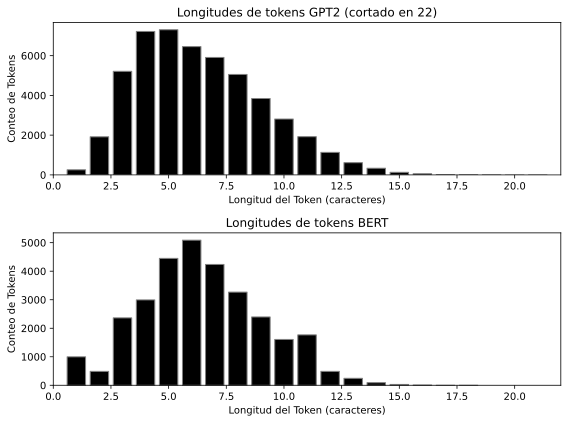

In [7]:
# ¡Dibujar el gráfico de barras!
_, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].bar(uniqueLengthsG, tokenCountG, color='k', edgecolor='gray')
axs[0].set(xlabel='Longitud del Token (caracteres)', ylabel='Conteo de Tokens',
           title='Longitudes de tokens GPT2 (cortado en 22)', xlim=[0, 22])

axs[1].bar(uniqueLengthsB, tokenCountB, color='k', edgecolor='gray')
axs[1].set(xlabel='Longitud del Token (caracteres)', ylabel='Conteo de Tokens',
           title='Longitudes de tokens BERT', xlim=[0, 22])

plt.tight_layout()
plt.show()

## 4. Visualización de la Matriz de Embeddings

Extraemos la matriz de pesos crudos.
* **Eje Y (Dimensiones):** 768 dimensiones para ambos modelos (en sus versiones base).
* **Eje X (Tokens):** El tamaño del vocabulario (~30k para BERT, ~50k para GPT-2).

Observa los patrones visuales en los mapas de calor. Las líneas verticales u horizontales indican dimensiones o tokens con comportamientos estadísticos particulares.

In [8]:
# Obtener la matriz de Word Token Embeddings de GPT-2
embeddingsG = gpt2.wte.weight.detach().numpy()

# Obtener la matriz de embeddings de BERT (¡nota los nombres de variables diferentes!)
embeddingsB = bert.embeddings.word_embeddings.weight.detach().numpy()

# Imprimir sus tamaños
print(f'La matriz de embeddings de BERT es de tamaño {embeddingsB.shape}.')
print(f'La matriz de embeddings de GPT2 es de tamaño {embeddingsG.shape}.')

La matriz de embeddings de BERT es de tamaño (30522, 768).
La matriz de embeddings de GPT2 es de tamaño (50257, 768).


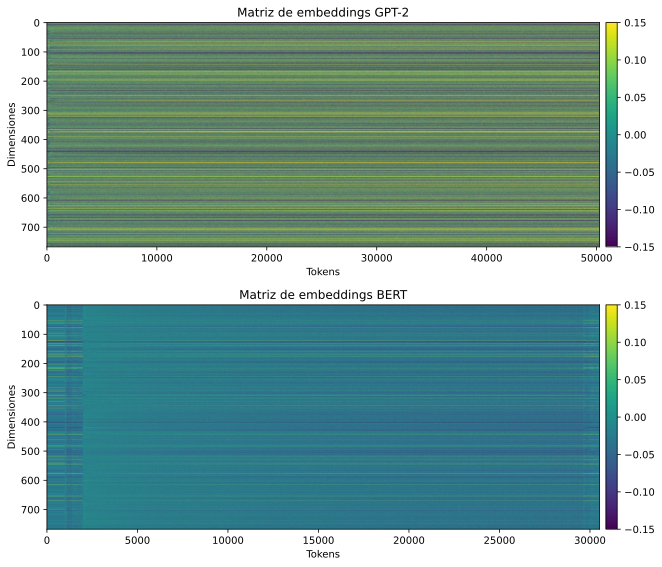

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Embeddings GPT
h = axs[0].imshow(embeddingsG.T, aspect='auto', vmin=-.15, vmax=.15)
axs[0].set(xlabel='Tokens', ylabel='Dimensiones', title='Matriz de embeddings GPT-2')
fig.colorbar(h, ax=axs[0], pad=.01)

# Embeddings BERT
h = axs[1].imshow(embeddingsB.T, aspect='auto', vmin=-.15, vmax=.15)
axs[1].set(xlabel='Tokens', ylabel='Dimensiones', title='Matriz de embeddings BERT')
fig.colorbar(h, ax=axs[1], pad=.01)

plt.tight_layout()
plt.show()

## 5. Comparación por Índice Numérico

Si tomamos el token número `15000` de BERT y el token número `15000` de GPT-2:
1.  ¿Son la misma palabra? (Probablemente no, porque usan diccionarios distintos).
2.  ¿Se parecen sus vectores?

Este experimento demuestra que el índice numérico es arbitrario entre modelos.

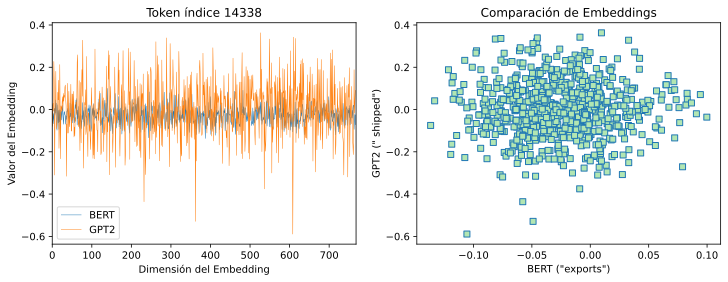

In [10]:
# Elegir un índice de token aleatorio
ridx = np.random.randint(10000, 20000)

_, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de líneas de los valores del vector
axs[0].plot(embeddingsB[ridx, :], label='BERT', linewidth=.5)
axs[0].plot(embeddingsG[ridx, :], label='GPT2', linewidth=.5)
axs[0].legend()
axs[0].set(xlabel='Dimensión del Embedding', ylabel='Valor del Embedding',
           xlim=[0, embeddingsB.shape[1]], title=f'Token índice {ridx}')

# Gráfico de dispersión
axs[1].plot(embeddingsB[ridx, :], embeddingsG[ridx, :], 's', markerfacecolor=[.7, .9, .7])
axs[1].set(xlabel=f'BERT ("{tokenizerB.decode(ridx)}")', ylabel=f'GPT2 ("{tokenizerG.decode(ridx)}")',
           title='Comparación de Embeddings')

plt.show()

## 6. Comparación de la Misma Palabra ("the")

Ahora buscamos la misma palabra semántica.
* Buscamos el ID de "the" en BERT (Nota: BERT añade tokens especiales, por eso usamos el índice `[1]`).
* Buscamos el ID de "the" en GPT-2.

¿Tienen una alta correlación sus vectores?
**Spoiler:** A menudo la correlación es baja (cerca de 0). Esto nos dice que el "espacio latente" de BERT y GPT-2 está rotado o estructurado de forma totalmente diferente, aunque ambos capturen el significado de "el/la".

BERT: "the" es el índice 1996
GPT2: "the" es el índice 1169


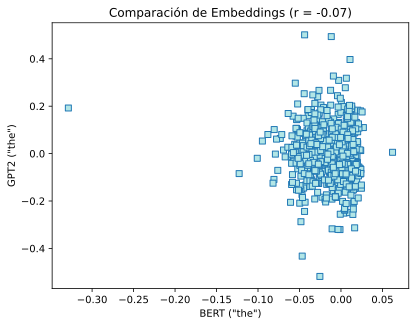

In [12]:
# ¿Qué tal la misma palabra?
token = 'the'
# BERT añade [CLS] al principio, así que tomamos el índice 1
token_idxB = tokenizerB.encode(token)[1]
# GPT2 no añade tokens especiales por defecto
token_idxG = tokenizerG.encode(token)[0]

print(f'BERT: "{token}" es el índice {token_idxB}')
print(f'GPT2: "{token}" es el índice {token_idxG}')

# Su correlación
corr = np.corrcoef(embeddingsB[token_idxB, :], embeddingsG[token_idxG, :])

plt.plot(embeddingsB[token_idxB, :], embeddingsG[token_idxG, :], 's', markerfacecolor=[.7, .9, .9])
plt.gca().set(xlabel=f'BERT ("{tokenizerB.decode(token_idxB)}")',
              ylabel=f'GPT2 ("{tokenizerG.decode(token_idxG)}")',
              title=f'Comparación de Embeddings (r = {corr[0, 1]:.2f})')

plt.show()

## 7. Distribuciones Estadísticas (Media y Varianza)

Finalmente, analizamos la "huella digital" estadística de los pesos.
* **Varianza:** ¿Cuánto varían los números dentro de un vector?
* **Media:** ¿Están los vectores centrados en cero?

Observa cómo la curva de BERT y GPT-2 difieren. Estas diferencias se deben a cómo se normalizan los datos dentro de la arquitectura (Layer Normalization) y cómo se entrenaron.

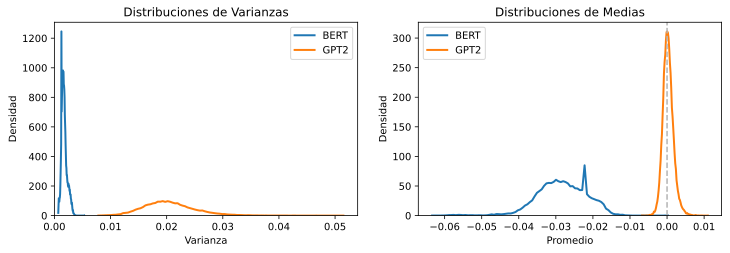

In [14]:
_, axs = plt.subplots(1, 2, figsize=(12, 3.5))

# Comparar las varianzas de los embeddings
yB, xB = np.histogram(embeddingsB.var(axis=1), bins=100, density=True)
yG, xG = np.histogram(embeddingsG.var(axis=1), bins=100, density=True)

axs[0].plot(xB[:-1], yB, linewidth=2, label='BERT')
axs[0].plot(xG[:-1], yG, linewidth=2, label='GPT2')
axs[0].set(xlabel='Varianza', ylabel='Densidad', xlim=[0, None], ylim=[0, None], title='Distribuciones de Varianzas')
axs[0].legend()

# Comparar las medias de los embeddings
yB, xB = np.histogram(embeddingsB.mean(axis=1), bins=100, density=True)
yG, xG = np.histogram(embeddingsG.mean(axis=1), bins=100, density=True)

axs[1].plot(xB[:-1], yB, linewidth=2, label='BERT')
axs[1].plot(xG[:-1], yG, linewidth=2, label='GPT2')
axs[1].axvline(0, color=[.7, .7, .7], linestyle='--')
axs[1].set(xlabel='Promedio', ylabel='Densidad', ylim=[0, None], title='Distribuciones de Medias')
axs[1].legend()

plt.show()